# Parameter tests

Tests for self-reliance, attitude, and fixed attitude influence

In [1]:
import os
import numpy as np
from importlib import reload
from dataclasses import *

import AvantgardeModelUtils
reload(AvantgardeModelUtils)
from AvantgardeModelUtils import *

BINARY_CLUSTER_BINS = np.arange(0, 1, 0.5)

In [66]:
location = "..\data\paramstest"
file = "agent_beta-avantgarde_"

files = []
for fname in os.listdir(location):
    if "-2.00" in fname and "-goal" in fname:        
        files.append(os.path.join(location, fname))
        
print(files)


['..\\data\\paramstest\\agent_data_beta-goal_a-18.00_b-2.00_m-0.90.csv', '..\\data\\paramstest\\agent_data_beta-goal_a-2.00_b-18.00_m-0.10.csv', '..\\data\\paramstest\\agent_data_beta-goal_a-2.00_b-2.00_m-0.50.csv', '..\\data\\paramstest\\agent_data_beta-goal_a-2.00_b-3.00_m-0.40.csv', '..\\data\\paramstest\\agent_data_beta-goal_a-2.00_b-4.67_m-0.30.csv', '..\\data\\paramstest\\agent_data_beta-goal_a-2.00_b-8.00_m-0.20.csv', '..\\data\\paramstest\\agent_data_beta-goal_a-3.00_b-2.00_m-0.60.csv', '..\\data\\paramstest\\agent_data_beta-goal_a-4.67_b-2.00_m-0.70.csv', '..\\data\\paramstest\\agent_data_beta-goal_a-8.00_b-2.00_m-0.80.csv']


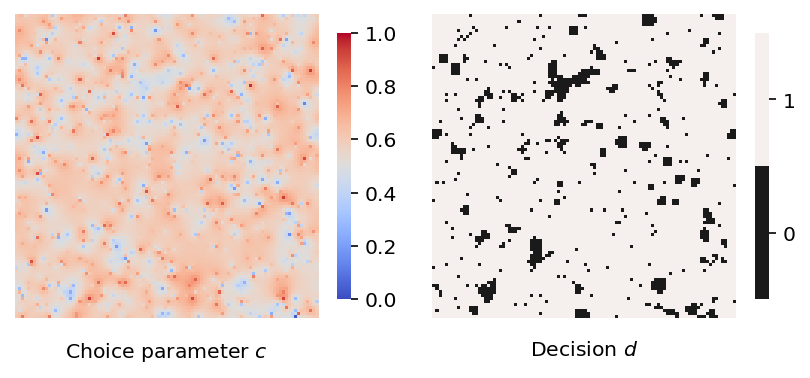

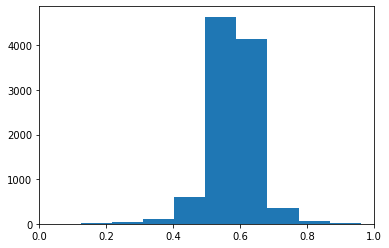

In [76]:
# show file
file = files[6]
columns = ["step", "id", "avantgarde", "affinity", "affinityGoal", "seed"]
data = LoadSimulation(file, columns=columns)

finalstep = 1000

xseed = 100
sample = data.query("seed == @xseed")

ShowState(Grid(Choice(sample, finalstep)))

plt.figure()
plt.hist(sample.query("step == @finalstep").get("affinity"), bins=10)
plt.xlim([0, 1])
plt.show()

In [81]:
columns = ["step", "id", "avantgarde", "affinity", "affinityGoal", "seed"]


In [196]:
plot_data = {}

keys = ("avantgarde", "affinityGoal", "affinity")
fkeys = ("avantgarde", "goal", "affinity")
for num in ("2.00", "5.00"):
    plot_data[num] = {}
    
    for (key, fkey) in zip(keys, fkeys):

        # select files
        location = "..\data\paramstest"
        file = "agent_beta-avantgarde_"

        files = []
        for fname in os.listdir(location):
            if f"-{num}" in fname and f"-{fkey}" in fname:        
                files.append(os.path.join(location, fname))

        # load data
        x, means, stds = [], [], []
        for file in files:
            data = LoadSimulation(file, columns=columns)

            # calculate properties
            xi = data.query("step == 0").get(key).mean()
            m = data.query("step == @finalstep").groupby("seed").mean().get("affinity")
            std = data.query("step == @finalstep").groupby("seed").std().get("affinity")

            x.append(xi)
            means.append(m)
            stds.append(std)

        # save
        plot_data[num][key] = {"x": x, "m": means, "std": stds}

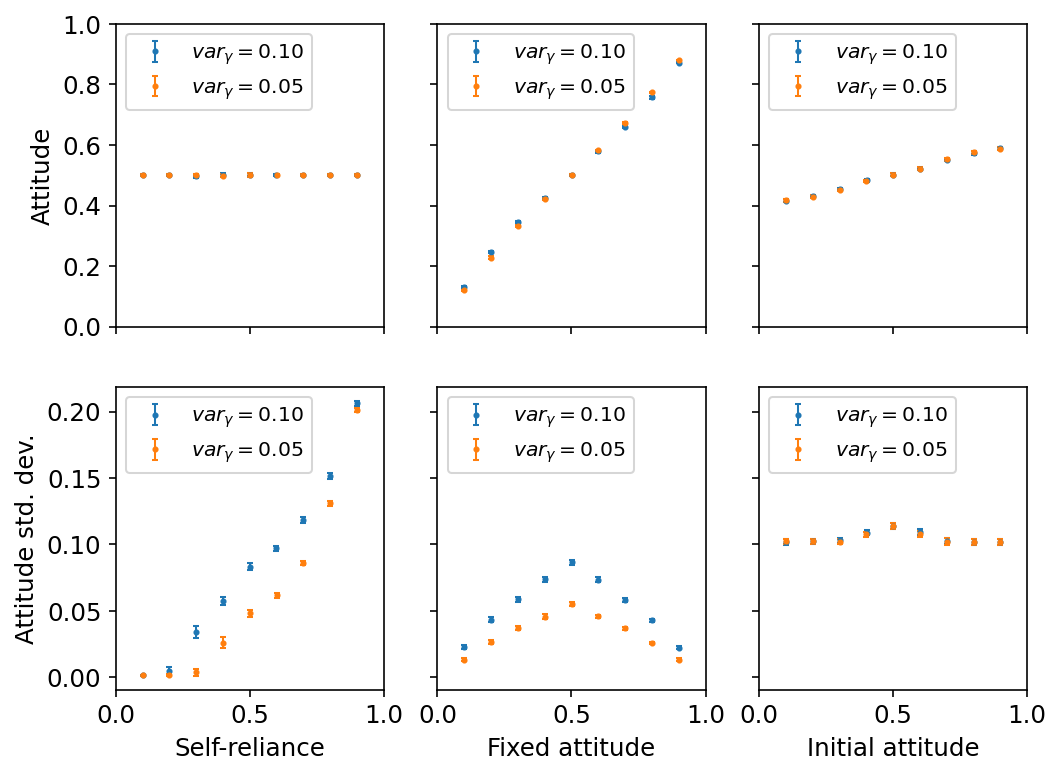

In [297]:
fig, ax = plt.subplots(2, 3, sharey="row", sharex="col", figsize=(8, 6))

plt.rcParams.update({"figure.dpi": 147, "font.size": 12})

labels = ("Self-reliance", "Fixed attitude", "Initial attitude")
# plot mean
for i, axis in enumerate(ax[0]):
    key = keys[i]
    for num, _data in plot_data.items():
        var = 1./(2 * (2 * float(num) + 1))
        axis.errorbar(_data[key]["x"], [_x.mean() for _x in _data[key]["m"]], 
                      yerr=[_x.std() for _x in _data[key]["m"]], 
                      marker="o", ms=2, linestyle="", capsize=1.5, elinewidth=1.,
                      label=fr"$var_\gamma={var:.2f}$")
        
        
    axis.set_ylim([0, 1])
    axis.legend(fontsize=10, loc="upper left")
    

# plot variance
for i, axis in enumerate(ax[1]):
    key = keys[i]
    for num, _data in plot_data.items():
        var = 1./(2 * (2 * float(num) + 1))
        axis.errorbar(_data[key]["x"], [_x.mean() for _x in _data[key]["std"]], 
                      yerr=[_x.std() for _x in _data[key]["std"]],
                      marker="o", ms=2, linestyle="", capsize=1.5, elinewidth=1.,
                      label=fr"$var_\gamma={var:.2f}$")
    
    axis.set_xlim([0, 1])
    axis.legend(fontsize=10, loc="upper left")
    axis.set_xlabel(labels[i], fontsize=12)

ax[0, 0].set_ylabel("Attitude")
ax[1, 0].set_ylabel(r"Attitude std. dev.")
plt.show()

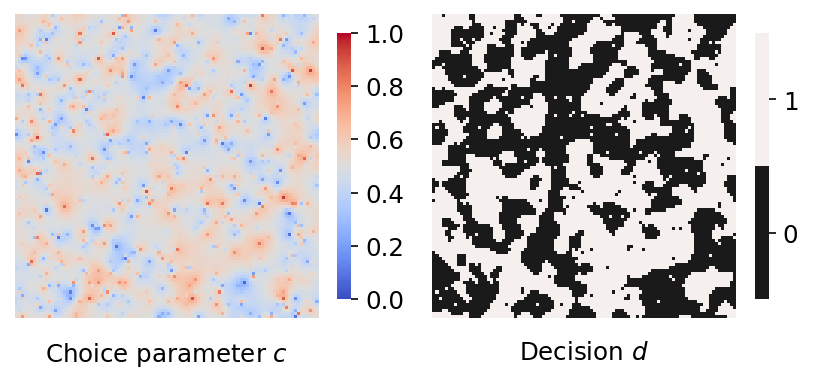

In [210]:
location = "..\data\paramstest"
file = "agent_beta-avantgarde_"

files = []
for fname in os.listdir(location):
    if "-2.00" in fname and "-avantgarde" in fname:        
        files.append(os.path.join(location, fname))
    
# show file
file = files[2]
columns = ["step", "id", "avantgarde", "affinity", "affinityGoal", "seed"]
data = LoadSimulation(file, columns=columns)

finalstep = 1000

xseed = 100
sample = data.query("seed == @xseed")

ShowState(Grid(Choice(sample, finalstep)))

# plt.figure()
# plt.hist(sample.query("step == @finalstep").get("affinity"), bins=10)
# plt.xlim([0, 1])
# plt.show()

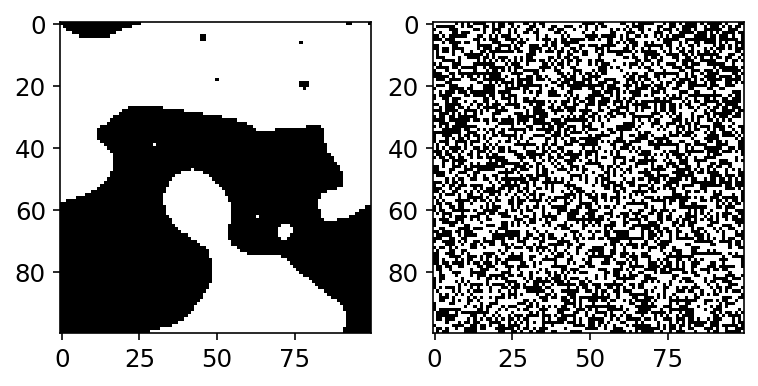

In [173]:
def PDecision(array):
    rnd_numbers = numpy.random.rand(array.size)
    return np.array([x < y for x, y in zip(rnd_numbers, array)])

_, ax = plt.subplots(1, 2)
ax[0].imshow(Grid(Choice(sample, 1000) < 0.5), cmap="binary")
ax[1].imshow(Grid(PDecision(Choice(sample, 1000))), cmap="binary")

In [175]:
import pymc3 as pm

with pm.Model() as model:
    # Define the prior for the coefficients
    beta0 = pm.Normal('beta0', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=10)

    # Define the likelihood
    likelihood = pm.Beta('likelihood', alpha=alpha, beta=beta, observed=Y)

    # Define the linear model
    mu = beta0 + beta1*X1

    # Define the posterior
    Y_pred = pm.Deterministic('Y_pred', mu)

with model:
    # Perform inference
    trace = pm.sample(draws=2000, tune=1000, chains=2)
    
coefs = trace.get_values('beta0', 'beta1')
pred

ModuleNotFoundError: No module named 'pymc3'

Text(0.5, 0, '$y_i$')

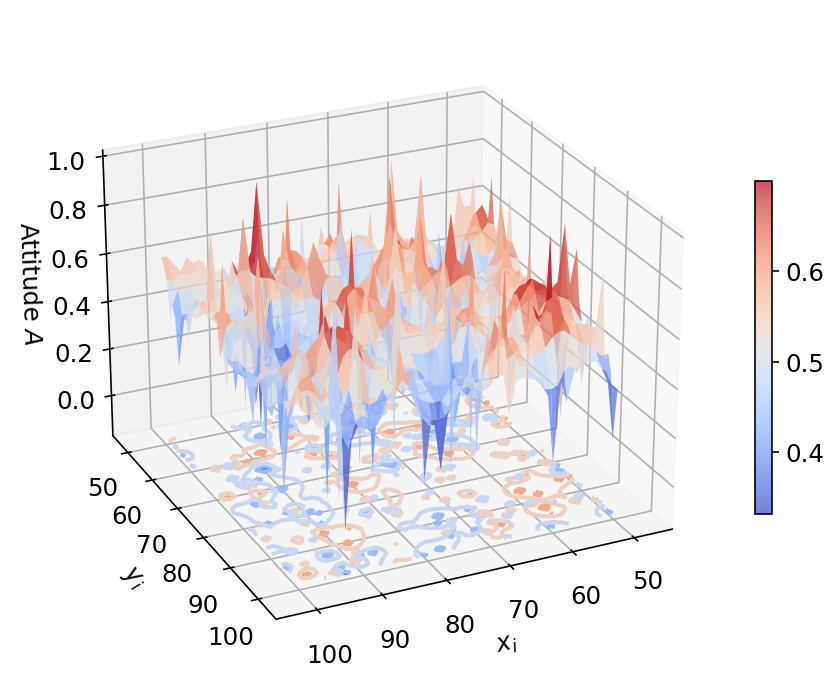

In [279]:
import matplotlib

file_uniform = "../data/distributions/agent_data_1000steps.csv"
data_uniform = LoadSimulation(file_uniform, columns=["step", "id", "affinity", "avantgarde", "affinityGoal", "seed"])

sample_uniform = data_uniform.query("seed == 100")

phi_m = np.linspace(50, 100, 50)
phi_p = np.linspace(50, 100, 50)
X,Y = np.meshgrid(phi_p, phi_m)
Z = Grid(Choice(sample_uniform, 1000))[50:, 50:]

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1, projection='3d')

offset = 5
cset=ax.plot_surface(X, Y, Z, rstride=2, cstride=2, alpha=0.7, cmap="coolwarm")
ax.contour(X, Y, Z, zdir='z', offset=-0.15, cmap="coolwarm", linewidths=2, linestyles='solid')

ax.set_xlim3d(-offset+50, 100 + offset)
ax.set_ylim3d(-offset+50, 100 + offset)
ax.set_zlim3d(-0.15, 1)
ax.set_proj_type('persp')
ax.view_init(elev=25, azim=65)
ax.grid(True)

plt.colorbar(cset, shrink=0.5)

ax.set_zlabel(r"Attitude $A$")
ax.set_xlabel(r"$x_i$")
ax.set_ylabel(r"$y_i$")
